# 0.0 Descrição do problema

Neste projeto treinaremos um modelo de Machine Learning, com o objetivo de prever o churn dos clientes de uma Telecom

#### <strong>Relevância do projeto</strong>:
Prever o churn dos clientes é crucial para qualquer empresa, uma vez que o cliente é o chefe que pode demitir todos os colabordaores da empresa, inclusive o CEO.
Dessa forma, entender fatores que podem influenciar os clientes em sua tomada de decisão de continuar ou não com a empresa é da mais alta importância. 

#### <strong>Características gerais</strong>:

O dataset é composto por:
  - 3333 instâncias
  - 21   variáveis


#### <strong>Objetivo</strong>:

Objetivo do projeto é selecionar  o melhor modelo entre DecisionTree, Random Forest, LGBM e Xgboost aplicar Otimização Bayesiana, encontrando assim os melhores parametros avaliar os resultados e proceder com a modelagem necessária.

#### <strong>Estratégia:</strong>

Neste projeto iremos trabalhar com quatro algoritmos de Machine Learning, Decision Tree, Random Forest, LigthGBM descreverei como funcionam, compararemos como ocorre a suas convergência e entenderemos os prós e contras de cada modelo. Trabalharemos também com o tunning de hyperparametros através da lib SklearnOpt aplicando otimização Bayesiana.

Para tal usaremos o Pydata stack: pandas, numpy, Sklearn, Skopt entre outras. 

In [112]:
#Importando os pacotes
#Proposito geral
import pandas as pd
import numpy as np
from collections import Counter
import re
import pickle
import warnings
warnings.filterwarnings("ignore")

#Visualização
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing

from sklearn.decomposition import PCA
from sklearn. preprocessing  import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.pipeline import FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from source import Mysql
from source import ToDenseTransformer

# Modelo
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import skopt

#Avaliação do Modelo
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, precision_score, recall_score
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.classifier import precision_recall_curve

# 1.0 Coleta de Dados

In [83]:
bd = Mysql()
QUERY = "SELECT * FROM treino_raw;"
treino = bd.retrieve_data(query = QUERY, user='brunods', password='Bruno2208', host='127.0.0.1',database='brunods')

In [84]:
# Visualizando o dataset.
treino.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


### 1.1 Análise Exploratoria - EDA

In [85]:

def diagnostico_dataset(dataset):
    
    #Informações Gerais
    print('Informações Gerais dos dados:')
    print('\n')
    dataset.info()
    #Checando por valores missing - Não temos valores missing
    print('\n')
    print('Diagnostico de valores Nulos:')
    print(f'Valores Nulos? {dataset.isnull().values.any()}')
    print(f'Proporção dos valores nulos? {dataset.isnull().mean().mean()}')

diagnostico_dataset(treino)

Informações Gerais dos dados:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3333 non-null   object 
 1   account_length                 3333 non-null   int64  
 2   area_code                      3333 non-null   object 
 3   international_plan             3333 non-null   object 
 4   voice_mail_plan                3333 non-null   object 
 5   number_vmail_messages          3333 non-null   int64  
 6   total_day_minutes              3333 non-null   float64
 7   total_day_calls                3333 non-null   int64  
 8   total_day_charge               3333 non-null   float64
 9   total_eve_minutes              3333 non-null   float64
 10  total_eve_calls                3333 non-null   int64  
 11  total_eve_charge               3333 non-null   float64
 12  total_night_minu

count     3333
unique       2
top         no
freq      2850
Name: churn, dtype: object




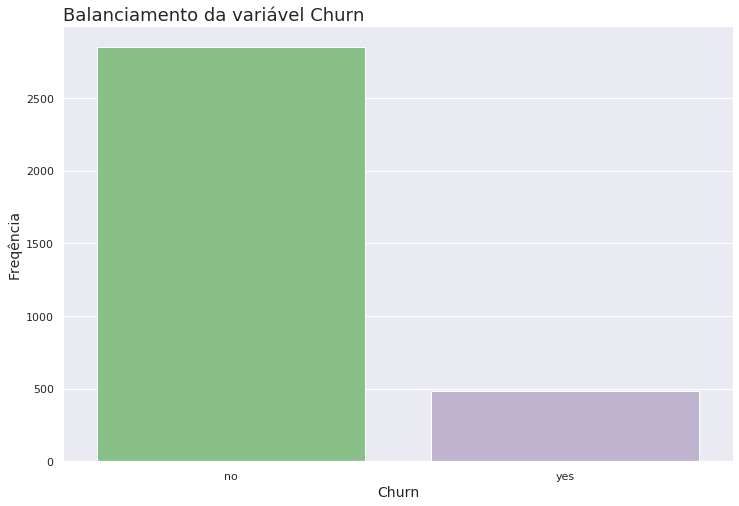

In [86]:
#Checando a porpocinalidade da variável target
#Precisaremos balancear o nosso dataset.
def balanced_target(target, dataset):
    print(dataset[target].describe())
    print('\n')

    sns.set(style = 'darkgrid', palette= 'Accent')
    ax = sns.countplot(x=target, data = dataset)
    ax.figure.set_size_inches(12,8)
    ax.set_title('Balanciamento da variável Churn', fontsize=18, loc='left')
    ax.set_xlabel('Churn', fontsize=14)
    ax.set_ylabel('Freqência', fontsize=14)
    ax=ax


balanced_target('churn', treino)

### 1.2 Top 10 estados

In [87]:
state = treino[['state','area_code']].groupby('state').count()
state = state.sort_values(by = 'area_code',ascending=False)
state.head(10)

,area_code
state,
WV,106
MN,84
NY,83
AL,80
OR,78
WI,78
OH,78
VA,77
WY,77


### 1.3 International_plan
- Ter um plano international não diminui as chances do clientes churn

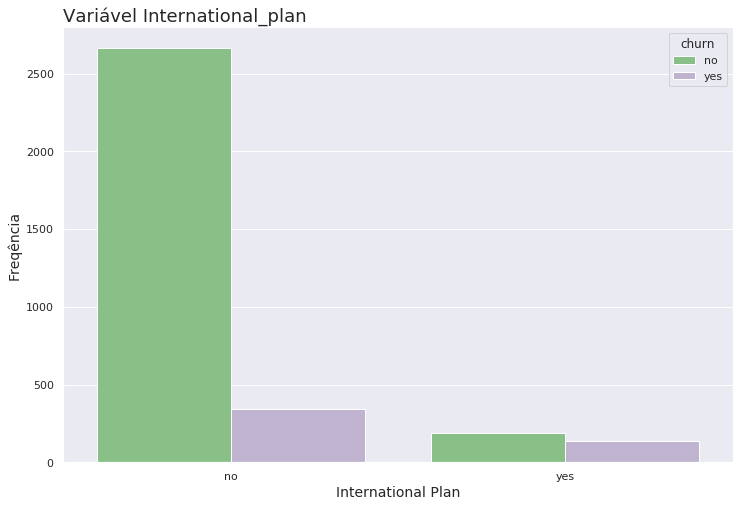

In [88]:
def international_plan(target, dataset):

    sns.set(style = 'darkgrid', palette = 'Accent')
    ax = sns.countplot(x=target, hue='churn', data = dataset)
    ax.figure.set_size_inches(12,8)
    ax.set_title('Variável International_plan', fontsize=18, loc='left')
    ax.set_xlabel('International Plan', fontsize=14)
    ax.set_ylabel('Freqência', fontsize=14)
    ax=ax

international_plan('international_plan', treino)

### 1.4 voice_mail_plan
- parcela pequena muito peguena de quem tem o plano de voz está flaguedo como churn.

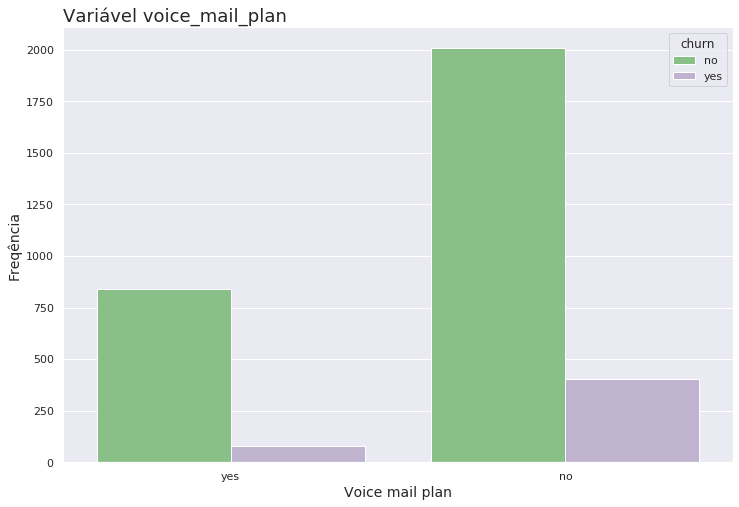

In [89]:
def voice_mail_plan(target, dataset):

    sns.set(style = 'darkgrid', palette = 'Accent')
    ax = sns.countplot(x=target, hue='churn', data = dataset)
    ax.figure.set_size_inches(12,8)
    ax.set_title('Variável voice_mail_plan', fontsize=18, loc='left')
    ax.set_xlabel('Voice mail plan', fontsize=14)
    ax.set_ylabel('Freqência', fontsize=14)
    ax=ax

voice_mail_plan('voice_mail_plan', treino)

### 1.5 total_day_minutes

- Os clientes parecem gastar mais munutos a tarde e noite que de pela manha ao telefone.
- Entre ps clientes com flag de churn , os mesmos, tem uma media de minutos maior em comparação com o comportamento da população.



Média total_day_minutes : 179.78
Desvio Padrão total_day_minutes : 54.47


Média total_eve_minutes : 200.98
Desvio Padrão total_eve_minutes : 50.71


Média total_night_minutes : 200.87
Desvio Padrão total_night_minutes : 50.57




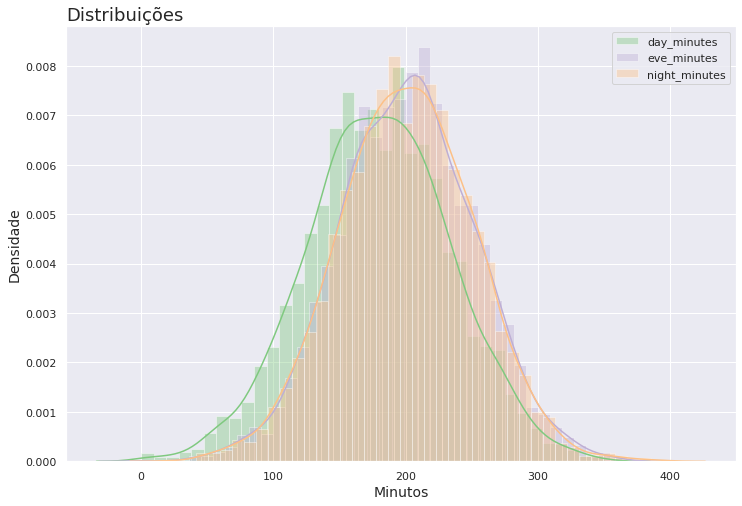

In [90]:
def international_plan(target, target1, target2, dataset):

    sns.set(style = 'darkgrid', palette = 'Accent')
    ax = sns.distplot(dataset[target], label = 'day_minutes')
    sns.distplot(dataset[target1], label = 'eve_minutes')
    sns.distplot(dataset[target2], label = 'night_minutes')
    ax.figure.set_size_inches(12,8)
    ax.set_title('Distribuições', fontsize=18, loc='left')
    ax.set_xlabel('Minutos', fontsize=14)
    ax.set_ylabel('Densidade', fontsize=14)
    plt.legend()
    ax=ax
    print('\n')
    print(f'Média {target} : {dataset[target].mean().round(2)}')
    print(f'Desvio Padrão {target} : {dataset[target].std().round(2)}')
    print('\n')
    print(f'Média {target1} : {dataset[target1].mean().round(2)}')
    print(f'Desvio Padrão {target1} : {dataset[target1].std().round(2)}')
    print('\n')
    print(f'Média {target2} : {dataset[target2].mean().round(2)}')
    print(f'Desvio Padrão {target2} : {dataset[target2].std().round(2)}')
    print('\n')

international_plan('total_day_minutes','total_eve_minutes','total_night_minutes', treino)



Média total_day_minutes : 206.91
Desvio Padrão total_day_minutes : 69.0


Média total_eve_minutes : 212.41
Desvio Padrão total_eve_minutes : 51.73


Média total_night_minutes : 205.23
Desvio Padrão total_night_minutes : 47.13




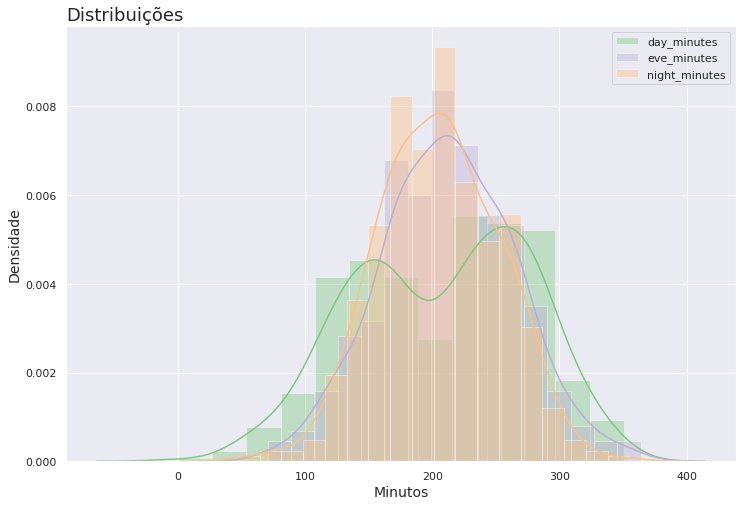

In [10]:
# Considerando somente os clientes com flag de churn
data = treino[treino['churn'] == 'yes']
international_plan('total_day_minutes','total_eve_minutes','total_night_minutes', data)

# 2.0 Construindo Pipeline e selecionando o modelo

Vamos construir o pipeline de transformações sobre os dados e serializar via arquivos pickle um pipeline para cada modelo que será utilizado no projeto.

Começarei separando os atributos categóricos dos númericos e criando pipelines para cada tipo de dados.

**Categóricos:**

OneHotEncoder é a representação de cada diferente categoria dos atributos em variáveis binárias.

A principal razão para realizarmos esse tipo de transformação é que muitos algoritmos de machine learning não conseguem lidar com dados categóricos diretamente, ou seja, os valores devem ser convertidos para números.
Uma segunda razão, é que o OneHotEncoding também funciona bem quando os dados possuem alguma relação ordinal (ruim, bom, muito bom) ou quando não possuem essa relação (gato, cachorro).

**Númericos:**

Para os dados númericos iremos aplicar discretização e posteriormente a transformação OneHotEncoder.
Discretização consite em agrupar os dados em faixas ou grupos, por exemplo, a variável idade quando a transformamos em faixa etária. Dessa forma podemos tratar os atributos númericos como se fossem categóricos
tranforma-los em variáveis binárias através do OneHotEncoding o que favorece muito os algoritmos baseados em árvore de decisão.   

In [117]:
# Pipeline completo.
#Separando variaveis x e y
x = treino.iloc[:,0:19]
y = treino['churn'].apply(lambda x : 1 if x == 'yes' else 0)

#Divisão entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, stratify= y , shuffle = True, random_state=0)

#Nome das variáveis
cat_vars = ['state','area_code','international_plan','voice_mail_plan']

num_vars = ['account_length', 'number_vmail_messages', 'total_day_minutes',
            'total_day_calls', 'total_day_charge','total_eve_minutes',              
            'total_eve_calls', 'total_eve_charge', 'total_night_minutes',            
            'total_night_calls','total_night_charge', 'total_intl_minutes',            
            'total_intl_calls', 'total_intl_charge','number_customer_service_calls']

#Estrategias de transformação
ohc = OneHotEncoder()
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')


#Pipeline das variáveis categoricas
categorical_pipeline = Pipeline(steps = [('ohc',ohc)])


#Pipeline das variaveis numericas
numerical_pipeline = Pipeline(steps = [('kbins',kbins),
                                       ('ohc',ohc)])

#ColumnTransformer
full_pipeline = ColumnTransformer([("categorical",categorical_pipeline,cat_vars),
                                   ("numerical", numerical_pipeline,num_vars)])



models = [('LR',LogisticRegression()),
          ('DT', DecisionTreeClassifier()),
          ('RF',RandomForestClassifier()),
          ('LGBM',lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', metric='binary_logloss')),
          ('XGB',xgb.XGBClassifier())]


for name,model in models:
    
#Pipeline de treino
    train_pipeline = Pipeline(steps=[('preprocessamento', full_pipeline),
                                             ('to_dense', ToDenseTransformer()),
                                             ('SMT', SMOTE(sampling_strategy='minority')),
                                             ('model', model)])
    train_pipeline.fit(X_treino,y_treino)
    resultado = cross_val_score(train_pipeline,X_teste,y_teste, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f'>>>>>>>>>{name}<<<<<<<<<<')
    print(f'Média - Teste: {np.mean(resultado)}')
    print(f'Desvio Padrão - Teste: {np.std(resultado)}')
    print('\n')
    
    file = f'../pipelines/{name}.sav'
    pickle.dump(train_pipeline, open(file, 'wb'))

>>>>>>>>>LR<<<<<<<<<<
Média - Teste: 0.7659236453201971
Desvio Padrão - Teste: 0.09867608896966523


>>>>>>>>>DT<<<<<<<<<<
Média - Teste: 0.6307204433497537
Desvio Padrão - Teste: 0.10861377413812155


>>>>>>>>>RF<<<<<<<<<<
Média - Teste: 0.8242056650246307
Desvio Padrão - Teste: 0.11582209159877499


>>>>>>>>>LGBM<<<<<<<<<<
Média - Teste: 0.8319458128078818
Desvio Padrão - Teste: 0.08754988732576391


>>>>>>>>>XGB<<<<<<<<<<
Média - Teste: 0.8268719211822659
Desvio Padrão - Teste: 0.08303923002250488




Como podemos observar acima o modelo LGBM alcançou a melhor performance média (AUC) de 0.83 com o menor desvio padrão 0.08.
Dessa forma vamos escolher o LGBM como nosso modelo a ser otimizado com a tecnica de otimização bayesiana.

# 3.0 LGBM

O que é LGBM?

According with the proper documentation of LightGBM, it is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.

- Lower memory usage.

- Better accuracy.

- Support of parallel and GPU learning.

- Capable of handling large-scale data.


The main diference of LightGBM compared with others tree-based algorithms, is that it grows the tree in a vertical way(leaf-wise) instead of horizontal way(level-wise). It will choose the leaf with max delta loss to grow and keep growing the same leaf, usually, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

The diagrams below may give a more visual compreension: 



Constraints:
Usually LightGBM does not work well in small datasets, there is no formal limit here but 10.000 instances would be a good number.

Main Parameters:

max_depth:
boosting_type:
learning_rate:
n_estimators:
num_leaves:
subsample:
min_split_gain:
min_split_weight:
min_child_samples:





# 3.1 Otimizando o LGBM

In [160]:
#LGBM  #('pca', PCA(n_components=40)),
space = [Integer(2,1000, name='max_depth'),
         Categorical(['gbdt'], name='boosting_type'),
         Real(0.01,0.5, name='learning_rate', prior='log-uniform'),
         Integer(1000,5000, name='n_estimators'),
         Integer(2,500, name='num_leaves'),
         Real(0.1,1.0, name='subsample', prior='uniform'),
         Real(0.1,1.00, name='colsample_bytree'),
         Integer(5,50, name='min_child_samples')]


def train_model_lgbm(params):
    max_depth = params[0]
    boosting_type = params[1]
    learning_rate = params[2]
    n_estimators = params[3]
    num_leaves = params[4]
    subsample = params[5]
    colsample_bytree = params[6]
    min_child_samples = params[7]
    
    #Pipeline LGBM
    lgbm_pipeline = Pipeline(steps=[('preprocessamento', full_pipeline),
                                ('to_dense', ToDenseTransformer()),
                                ('SMT', SMOTE(sampling_strategy='minority')),
                                ('lgbm', lgb.LGBMClassifier(max_depth=max_depth, 
                                                            boosting_type=boosting_type,
                                                            learning_rate=learning_rate,
                                                            n_estimators=n_estimators,
                                                            num_leaves=num_leaves,
                                                            subsample=subsample,
                                                            colsample_bytree=colsample_bytree,
                                                            min_child_samples=min_child_samples,
                                                            random_state=0,objective = 'binary', metric='binary_logloss'))])
    
    lgbm_pipeline.fit(X_treino,y_treino)
    p = -cross_val_score(lgbm_pipeline,X_treino,y_treino, cv=20, scoring='roc_auc')
    
    return np.mean(p)

result_LGBM = skopt.gp_minimize(train_model_lgbm, space, random_state=1,n_calls=50, n_random_starts = 10)

# 5.2 Treinando modelo com os parametros encontrados
Treinando com o modelo com os parametros encontrados pela Otimização Bayesiana conseguimos aumentar a nossa AUC média em 2 pontos alcançando 0.84.
Frente aos 0.82 obtidos na etapa de seleção do modelo.

In [162]:
model = Pipeline(steps=[('preprocessamento', full_pipeline),
                            ('to_dense', ToDenseTransformer()),
                            ('SMT', SMOTE(sampling_strategy='minority')),
                            ('lgbm', lgb.LGBMClassifier(max_depth=result_LGBM.x[0], 
                                                        boosting_type=result_LGBM.x[1],
                                                        learning_rate=result_LGBM.x[2],
                                                        n_estimators=result_LGBM.x[3],
                                                        num_leaves= result_LGBM.x[4],
                                                        subsample = result_LGBM.x[5],
                                                        colsample_bytree = result_LGBM.x[6],
                                                        min_child_samples = result_LGBM.x[7],
                                                        random_state=0,objective = 'binary', metric='binary_logloss'))])


model.fit(X_treino,y_treino)
resultado = cross_val_score(model,X_teste,y_teste, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f'Média - Teste: {np.mean(resultado)}')
print(f'Desvio Padrão - Teste: {np.std(resultado)}')
print('\n')

Média - Teste: 0.8137315270935961
Desvio Padrão - Teste: 0.10330734227603587




## 3.3 Avaliando o processo de otimização
Como podemos observar no grafico abaixo foi um encontrado um plataeu após a iteração 10.

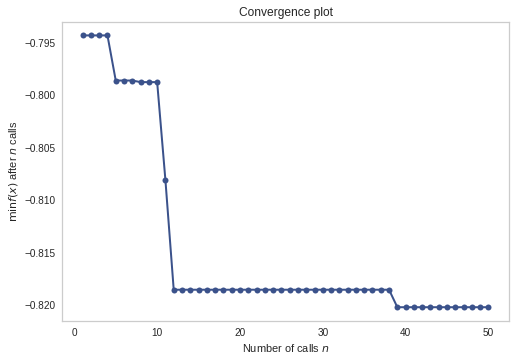

In [163]:
#LGBM Convergence
import skopt.plots
skopt.plots.plot_convergence(result_LGBM)

# 4.0 Interpretando o nosso modelo LGBM

Para os dados do teste, a AUC, após a otimização foi de 0.84 um ganho de 2pontos frente ao modelo não otimizado. No entanto, se analisarmos o recall, observamos o valor de 0,41, ou seja, de todos os eventos de 'churn', estamos classificando corretamente 41% da nossa categoria alvo.

Como esse desempenho não nos interessa,nosso objetivo aqui é prever o churn, poderíamos favorecer o recall frente a precision, dessa forma, começaríamos a classificar não_churn como churn porém acertaríamos a maioria dos clientes com perigo real de churn. 

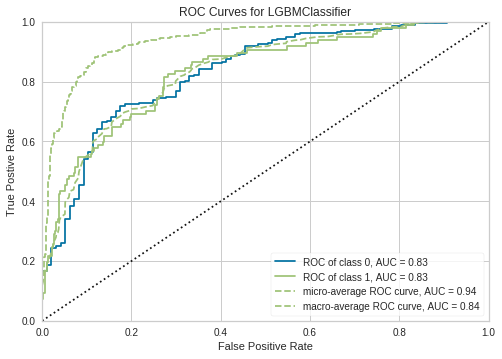

In [174]:
#ROC Curve
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(model, classes=["0", "1"])

visualizer.fit(X_treino, y_treino)         
visualizer.score(X_teste, y_teste)                                   
visualizer.show() 

A curva ROC é uma medida de desempenho para problemas de classificação em diferentes limites.

Através das curvas ROC acima, podemos ver que nosso modelo tem, em geral, as curvas tanto para classe 0 quanto para classe 1 andam aproximadamente juntas.

In [173]:
#Test Data
# Predict
pred = model.predict(X_teste)

# print classification report
print("Relatório de Classificação:\n", 
       classification_report(y_teste, pred, digits=2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       570
           1       0.64      0.43      0.52        97

    accuracy                           0.88       667
   macro avg       0.77      0.70      0.72       667
weighted avg       0.87      0.88      0.87       667



A partir da análise do relatório de classificação acima podemos observar que o recall (taxa de detecção) da nossa classe-alvo
é 0.43, abaixo de 0.5 que representaria um simples chute para melhorarmos. Tendo em vista que o nosso objetivo é prever exatamente o evento representado pela classe 1, devemos otimizar 
o recall dessa classe afim de detectarmos a maior parte dos casos de churn, não vamos alcançar esse objetivo sem sacrificarmos a 'precison' ou seja sem classificarmos alguns 'não_churn' como 'churn'. 

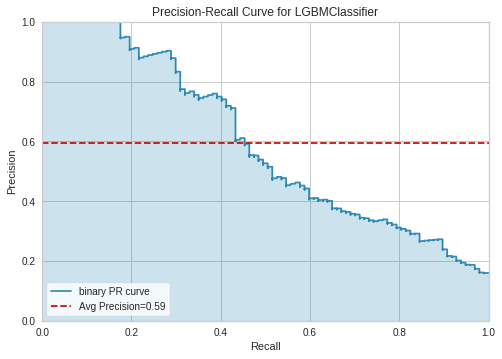

In [156]:
#Precision Recall Curve
viz = precision_recall_curve(model, X_treino, y_treino, X_teste, y_teste)

DiscriminationThreshold(argmax='fscore',
                        ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f802e0a90>,
                        cv=0.1, exclude=None, fbeta=1.0, force_model=None,
                        is_fitted='auto', model=None, n_trials=50,
                        quantiles=array([0.1, 0.5, 0.9]), random_state=None)

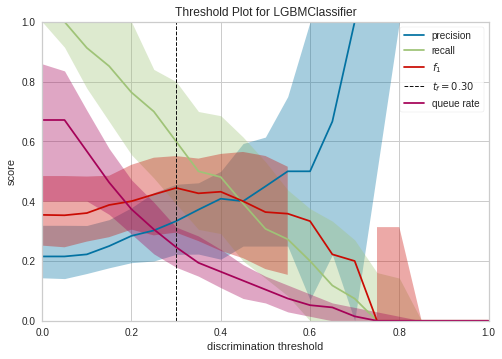

In [170]:
#Threshold
discrimination_threshold(model, X_teste, y_teste)

A partir do plot acima podemos analisar o trade-off entre precision e recall. Provavel se usarmos um threshold de 0.15 o recall irá para ficara entre 0.85 a 0.90.
Vamos experimentar esta hipotese abaixo.

In [171]:
#Transformando predições em binárias
pred_prob = model.predict_proba(X_teste)

for i in range(0,len(pred_prob)):
    if pred_prob[i,1] >= 0.15:
        pred_prob[i,1] = 1
    else:
        pred_prob[i,1] = 0
        
# print classification report
print("Relatório de Classificação:\n", 
       classification_report(y_teste, pred_prob[:,1], digits=2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.47      0.63       570
           1       0.23      0.91      0.36        97

    accuracy                           0.54       667
   macro avg       0.60      0.69      0.50       667
weighted avg       0.86      0.54      0.59       667



Podemos observar que atingimos um recall de 0.91, ou seja, somos capazes agora de detectar 91% dos casos de churns em nossos dados de teste. O que é uma performance satisfatória.